# Lab 1

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

im_dungeon = np.array(Image.open("../Images_TP/donjon.png"))
im_lena = np.array(Image.open("../Images_TP/Lena.jpg"))
im_aquitain = np.array(Image.open("../Images_TP/aquitain.tif"))

# Image.fromarray(im_dungeon).show()
def show(im,im_ref=im_dungeon,cmap= 'viridis',cmap_ref='viridis'):
    f, axarr = plt.subplots(1,2)    #subplot(r,c) provide the no. of rows and columns
    axarr[0].set_title('After')
    axarr[0].imshow(im,cmap=cmap)
    axarr[1].set_title('Before')
    axarr[1].imshow(im_ref,cmap=cmap_ref)

def build_histo(im):
    assert(len(im.shape)==2)    #ne supporte qu'une couleur
    nb_classes = 256
    histo = [0]*nb_classes
    for i in im.ravel():
        histo[int(i)] += 1
    return histo

def show_histo(hist,title='Histogramme'):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    plt.bar(range(256), hist, color='gray')

def build_histo_cumul(histo):
    histo_cumul = np.empty_like(histo)
    temp = 0
    for i,h in enumerate(histo):
        temp += h 
        histo_cumul[i] = temp
    return histo_cumul


## 1. Filtre Rouge

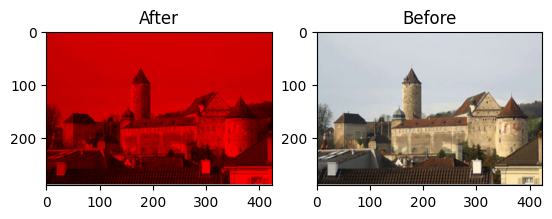

In [2]:
def filter_red(im) :
    im_R = im.copy()
    im_R[:, :, (1, 2)] = 0
    return Image.fromarray(im_R)

im_temp = filter_red(im_dungeon)
show(im_temp)

## 2. Filtre Invert

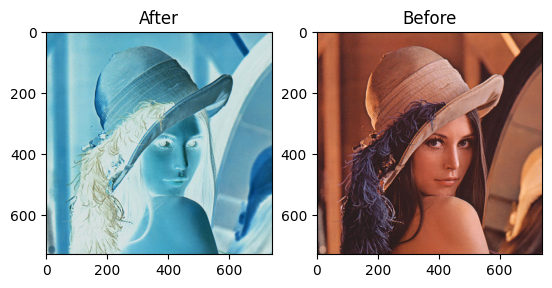

In [3]:
def filter_invert(im):
    return 255 - im

im_temp = filter_invert(im_lena)
show(im_temp,im_lena)

## 3. Filtre Grey

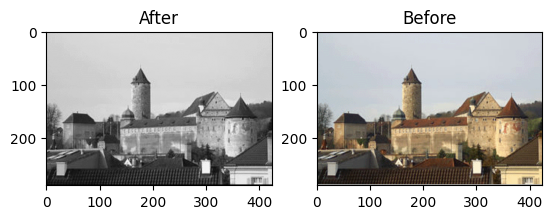

In [4]:
# im_temp = np.array(Image.open("../Images_TP/donjon.png").convert('L'))

def grey(im):
    R, G, B = im[:, :, 0], im[:, :, 1], im[:, :, 2]
    return 0.2989 * R + 0.5870 * G + 0.1140 * B

im_temp = grey(im_dungeon)
show(im_temp, cmap="gray")

## 4. Filtre Sepia

outputRed = (inputRed * .393) + (inputGreen *.769) + (inputBlue * .189) \
outputGreen = (inputRed * .349) + (inputGreen *.686) + (inputBlue * .168) \
outputBlue = (inputRed * .272) + (inputGreen *.534) + (inputBlue * .131) \
NB : en cas de saturation (intensité résultante>255), mettre la valeur à 255.

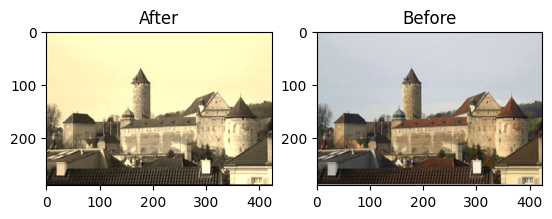

In [5]:


def sepia(im) :
    inputRed, inputGreen, inputBlue = im[:, :, 0], im[:, :, 1], im[:, :, 2]
    R = inputRed * .393 + (inputGreen *.769) + (inputBlue * .189)   #R.dtype = float64
    G = (inputRed * .349) + (inputGreen *.686) + (inputBlue * .168)
    B = (inputRed * .272) + (inputGreen *.534) + (inputBlue * .131)
    R[R > 255] = 255   
    G[G > 255] = 255
    B[B > 255] = 255

    imgSepia = np.empty_like(im,shape=(im.shape[0],im.shape[1],3))
    imgSepia[:,:,0] = R # auto convert dtype
    imgSepia[:,:,1] = G
    imgSepia[:,:,2] = B
    return imgSepia

im_temp = sepia(im_dungeon)
show(im_temp)

## 5. Contrast

Pour chaque composante de chaque pixel, appliquez les règles suivantes : \
a.  Si la valeur est plus petite que 30, assignez la valeur 0. \
b.  Si la valeur est plus grande que 225, assignez la valeur 255. \
c.  Les valeurs c comprises entre 30 et 225 seront recalculées avec la formule : (255.0 / 195.0) * (c - 30) + 0.5 \
Avec une calculatrice, vous constaterez que, par exemple : 30 devient 0, 225  devient  255,  45  devient  20,  180  devient  196,  120  devient  118.  \
Les valeurs "s'écartent" les unes des autres, ce qui augmente le contraste.

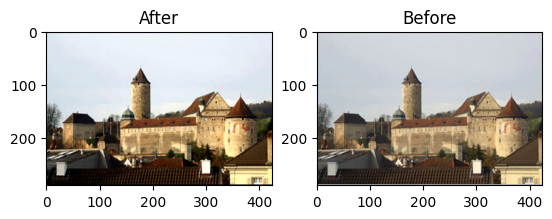

In [6]:


def filter_contrast(im):
    img = im[:,:,(0,1,2)]   #copy RGB
    img[img < 30 ] = 0
    img[img > 225] = 255
    index_c = np.where((img >30 )&(img < 225))
    img[index_c] = (255.0 / 195.0) * (img[index_c] - 30) + 0.5
    return img

im_temp = filter_contrast(im_dungeon)
show(im_temp)

#Rq : auto-contrast / normalise : I'(x,y)=255*(I(x,y)-Imin)/(Imax-Imin)

## 6. Seuillage

Seuillage\
On remplace un à un les pixels d'une image par rapport à une valeur seuil fixée (par exemple 123). \
Ainsi, si un pixel à une valeur supérieure au seuil (par exemple 150), il prendra la valeur 255 (blanc),\
et si sa valeur est  inférieure  (par  exemple  100),  il  prendra  la  valeur  0  (noir).  \
Appliquez  une  méthode  de seuillage automatique / adaptatif et comparez le seuil obtenu avec le seuil suggéré. \
Tracez l’histogramme de l’image et analysez le seuil automatique \
par rapport à la configuration de l’histogramme. Faites un commentaire dans le code à ce sujet.

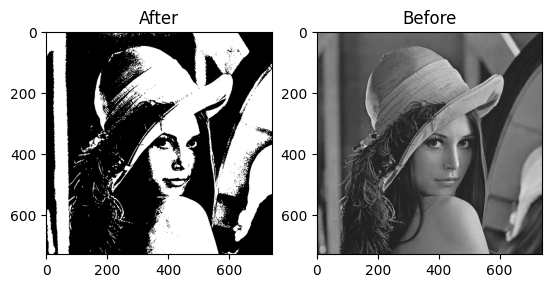

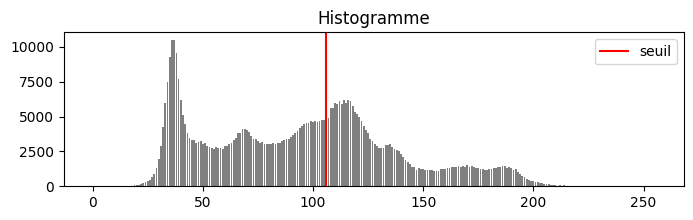

In [7]:
def threshold(im,seuil):
    if(len(im.shape)>2):        #if RGB ou RGBa
        img = im[:,:,(0,1,2)]   #convertit RGBa/RGB en RGB et copie
    else:
        img = np.copy(im)
    img[img < seuil ] = 0
    img[img > seuil] = 255
    return img

im_lena_gray = grey(im_lena)
seuil = 106
im_temp = threshold(im_lena_gray,seuil)
show(im_temp,im_lena_gray,cmap="gray",cmap_ref="gray")

histo = build_histo(im_lena_gray)
show_histo(histo)
line = plt.axvline(x=seuil, color='red')
plt.legend([line],['seuil'])

seuil suggéré : 136


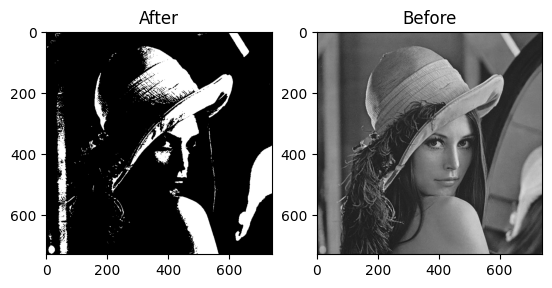

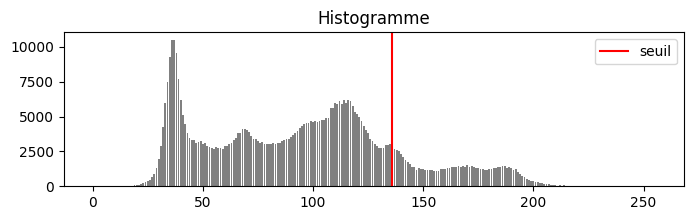

In [8]:
def threshold_finder_gray(im):
    #nécessite une image en gris
    #trouve un seuil qui maximise la variance inter-Classe

    hist = build_histo(im)
    #normalise l'histogramme
    nb_niveaux = len(hist)
    size_image = im.shape[0] * im.shape[1]
    for col in range(0,nb_niveaux):
        hist[col] /= size_image   #hist devient la densité de probabilité

    #calcule les variances inter-classes pour toutes les classes possibles
    variancesInter = np.empty(shape=[nb_niveaux])
    mean_image = np.mean(hist)
    for seuil in range(1,nb_niveaux-1): #seuil : séparateur de classes
        #taille min de Classe1 et Classe2 = 1 niveau
        #proba que pixel appartienne à la Classe1
        proba_C1 = np.sum(hist[0:seuil])
        #variance inter-classe 1 et 2
        mean_C1 = np.mean(hist[0:seuil]) 
        mean_C2 = np.mean(hist[seuil:])
        varC1C2= proba_C1*(mean_C1 - mean_image)**2 + (1 - proba_C1)*(mean_C2 - mean_image)**2
        variancesInter[seuil] = varC1C2
    variancesInter[0] = 0 ; variancesInter[-1] = 0
    #trouve le seuil pour la varaince inter-classe maximale
    seuil_maxVarInter = np.argmax(variancesInter)
    return seuil_maxVarInter

seuil = threshold_finder_gray(im_lena_gray)
print("seuil suggéré :",seuil)

im_temp = threshold(im_lena_gray,seuil)
show(im_temp,im_lena_gray,cmap="gray",cmap_ref="gray")

histo = build_histo(im_lena_gray)
show_histo(histo)
line = plt.axvline(x=seuil, color='red')
plt.legend([line],['seuil'])

seuil suggéré : 137


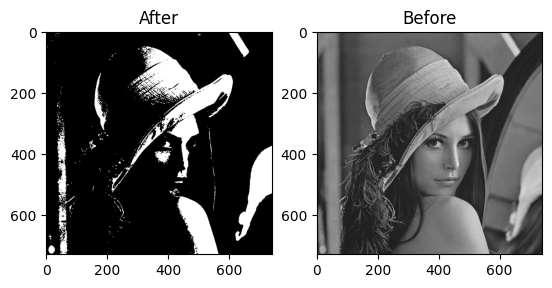

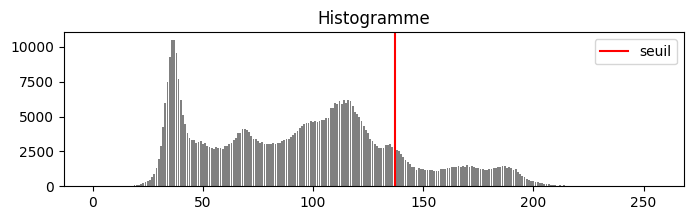

In [9]:
def threshold_gray_finder2(im):
    #nécessite une image en gris
    #trouve un seuil qui maximise le ratio (variance inter-Classes/variance intra-Classes)
    
    hist = build_histo(im)

    #normalise l'histogramme
    nb_niveaux = len(hist)
    size_image = im.shape[0] * im.shape[1]
    for col in range(0,nb_niveaux):
        hist[col] /= size_image   #hist devient la densité de probabilité

    #calcule les (variances inter-classes/variances intra) pour toutes les classes possibles
    variancesRatio = np.empty(shape=[nb_niveaux])
    mean_image = np.mean(hist)
    for seuil in range(1,nb_niveaux-1): #seuil : séparateur de classes
        #taille min de Classe1 et Classe2 = 1 niveau
        #proba que pixel appartienne à la Classe1
        proba_C1 = np.sum(hist[0:seuil])
        proba_C2 = 1 - proba_C1
        #variance inter-classe 1 et 2
        mean_C1 = np.mean(hist[0:seuil]) 
        mean_C2 = np.mean(hist[seuil:])
        varInter= proba_C1*(mean_C1 - mean_image)**2 + proba_C2*(mean_C2 - mean_image)**2
        varIntra = proba_C1*np.std(hist[0:seuil]) + proba_C2*np.std(hist[seuil:])
        variancesRatio[seuil] = varInter/varIntra
    variancesRatio[0] = 0 ; variancesRatio[-1] = 0
    #trouve le seuil pour la varaince inter-classe maximale
    seuil_maxVarInter = np.argmax(variancesRatio)
    return seuil_maxVarInter

seuil = threshold_gray_finder2(im_lena_gray)
print("seuil suggéré :",seuil)

im_temp = threshold(im_lena_gray,seuil)
show(im_temp,im_lena_gray,cmap="gray",cmap_ref="gray")

histo = build_histo(im_lena_gray)
show_histo(histo)
line = plt.axvline(x=seuil, color='red')
plt.legend([line],['seuil'])

Ces seuillages automatique ne sont pas ici interressants car les niveaux de gris ne permettent pas de séparer nettement le portrait du fond. On ne voit pas de classes franchement dissociées.\
De plus le seuillage auto ne considère qu'il n'y a que 2 classes, ce n'est pas le cas ici, il y a plusieurs pics

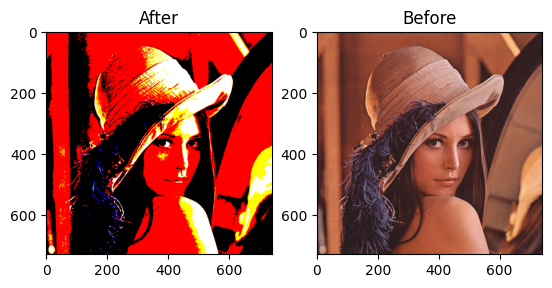

In [10]:
seuil = 123
im_temp = threshold(im_lena,seuil)
show(im_temp,im_lena)

## 7. Flip

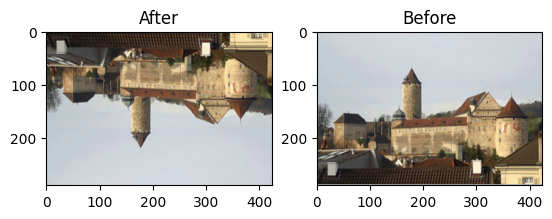

In [11]:
def flip_horizontal(im):
    img = im[::-1,:,:]   #copie
    return img

im_temp = flip_horizontal(im_dungeon)
show(im_temp)

## 8. bord

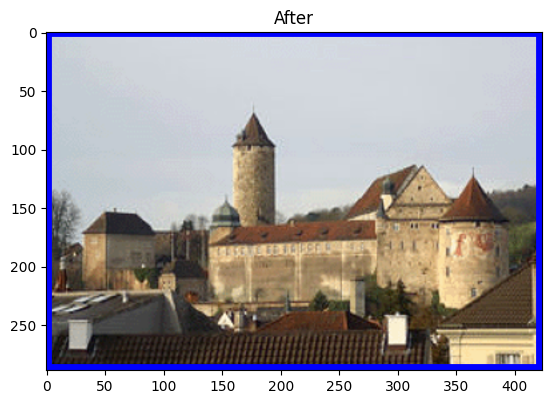

In [12]:
def bord_bleu(im,width):
    img = im[:,:,(0,1,2)]   #convertit RGBa/RGB en RGB
    img[0:width,:]=[0,0,255]
    img[-width:,:]=[0,0,255]
    img[:,0:width]=[0,0,255]
    img[:,-width:]=[0,0,255]
    return img

im_temp = bord_bleu(im_dungeon,5)
plt.title("After")
plt.imshow(im_temp)


## 9. Relief

Créer un bord qui donnera une impression de relief. Il sera constitué de 4 régions 
polygonales d'une largeur de 10 pixels. Les pixels de la région du haut seront éclaircis de 65, 
ceux de la région du bas assombris de 65. A droite et à gauche, ils seront assombris de 40. La 
difficulté de l'exercice réside dans la gestion des coins...

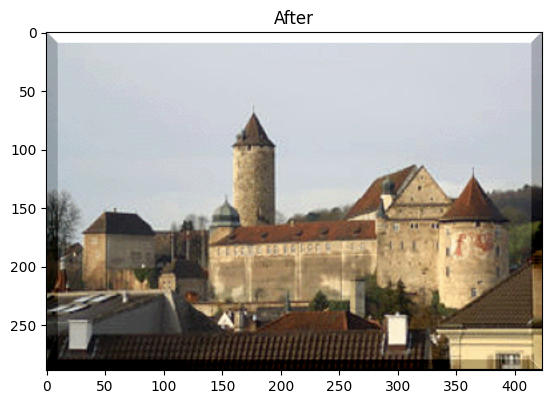

In [13]:
def relief(im):
    img = np.array(im[:,:,(0,1,2)])   #convertit RGBa/RGB en RGB
    img = img.astype(np.uint32)

    for i in range(0,10):   #angles
        #haut
        img_sup = img[i,i:-i]   #passage par pointeur
        img_sup += 65
        img_sup[img_sup > 255] = 255
        #bas
        img_bot = img[-i,i:-i]
        img_bot -= 65
        img_bot[img_bot > 255] = 0
        #left
        img_left = img[i:-i,i]
        img_left -= 40
        img_left[ img_left > 255] = 0
        #right
        img_right = img[i:-i,-i]
        img_right -= 40
        img_right[ img_right > 255] = 0

    return img.astype(np.uint8)

im_temp = relief(im_dungeon)
plt.title("After")
plt.imshow(im_temp)

## 10. Pixeliser

L'idée est de diviser l'image en carrés de 10 pixels sur 10 (dans les bords, ce 
seront des rectangles). Dans un "carré", chaque composante de chaque pixel sera la valeur 
moyenne du carré. 

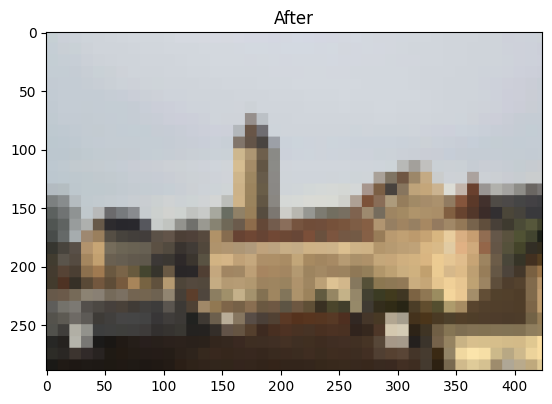

In [14]:
def pixelize(im,size):
    img = im[:,:,(0,1,2)]   #copie RGB
    for piy in range(0,(len(img)//size)+1):
        for pix in range(0,(len(img[0])//size)+1):
            img_square = img[piy*size : min((piy+1)*size,len(img)), pix*size : min((pix+1)*size,len(img[0])), : ]
            img_square[:,:,0] = np.mean(np.array(img_square[:,:,0]))
            img_square[:,:,1] = np.mean(np.array(img_square[:,:,1]))
            img_square[:,:,2] = np.mean(np.array(img_square[:,:,2]))
    return img
im_temp = pixelize(im_dungeon,10)
plt.title("After")
plt.imshow(im_temp)

## 11. Visibilité

 Que doit-on faire pour augmenter la lisibilité de l’image aquitain.tif (dans le dossier du 
TP) ? Mettre en œuvre vos différentes suggestions dans le cadre d’un script (Python). 

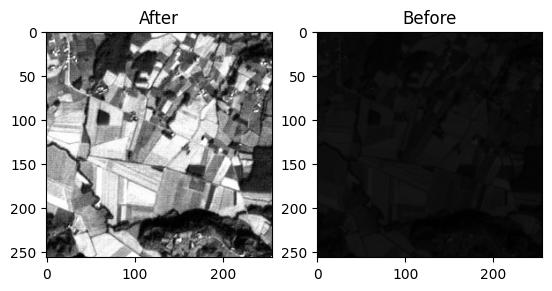

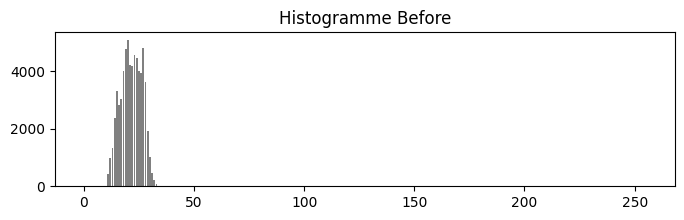

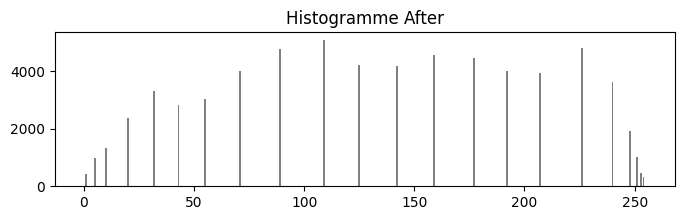

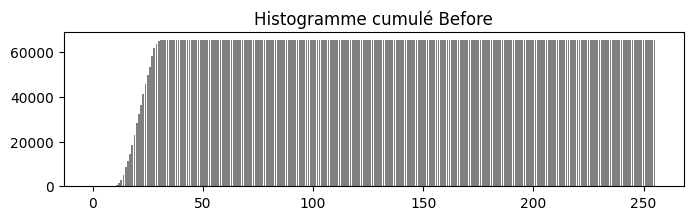

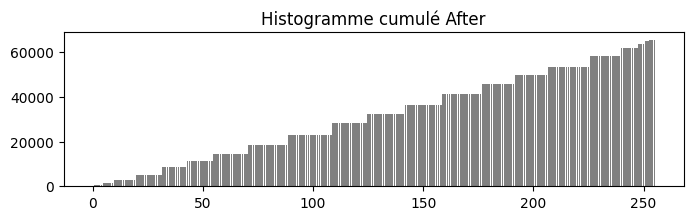

In [16]:
def normalize(im):
    img = np.copy(im)
    img_max = np.max(img)
    img_min = np.min(img)
    img = 255 * ((img-img_min)/(img_max-img_min))
    return img
#Rq : auto-contrast/normalise : I'(x,y)=255*(I(x,y)-Imin)/(Imax-Imin)

def equalise(im) :
    img = np.copy(im)
    #construit l'histogramme
    proba_k = np.empty([256])
    for x in img.ravel():   # k : classes (niveaux de gris)
        proba_k[int(x)] += 1
    nb_classes = len(proba_k)
    #normalise l'histogramme
    size_image = img.shape[0]*img.shape[1]  # =539460
    for k in range(0,nb_classes):
        proba_k[k] /= size_image   #col_liste = probabilité par classes
    #transforme (uniformise la répartition des niveaux de gris)
    for y in range(0,len(img)):
        for x in range(0,len(img[0])):
            img[y,x] = (nb_classes-1) * sum([proba_k[k] for k in range(0,int(img[y,x]+1))])
    return img

im_temp = normalize(im_aquitain)
im_temp = equalise(im_temp)

show(im_temp,im_aquitain,cmap="gray",cmap_ref="gray")
hist_temp1 = build_histo(im_aquitain)
hist_temp2 = build_histo(im_temp)
show_histo(hist_temp1,'Histogramme Before')
show_histo(hist_temp2,'Histogramme After')

show_histo(build_histo_cumul(hist_temp1),'Histogramme cumulé Before')
show_histo(build_histo_cumul(hist_temp2),'Histogramme cumulé After')

## 12. Filtres (convolutions)

In [ ]:
def linear_filter_RGB(im,filtre):
    height, width, nb_channels = im.shape
    size_filtre = filtre.shape[0]
    assert(nb_channels < 4)        #besoin image RGB
    assert(size_filtre%2 == 1) #filtre carré de taille impaire
    bord = size_filtre//2
    img = np.zeros_like(im)
    for y in range(bord,height-bord):
        for x in range(bord,width-bord):
            for c in range(0,nb_channels):
                temp = np.sum(im[y-bord:y+bord+1,x-bord:x+bord+1,c]*filtre)    #temp : float64
                img[y,x,c] = temp*(temp>=0) if (temp<255) else 255    #saturation
    return img

def linear_filter_grey(im,filtre):
    height, width = im.shape
    size_filtre = filtre.shape[0]
    assert(size_filtre%2 == 1) #filtre carré de taille impaire
    bord = size_filtre//2
    img = np.zeros_like(im)
    for y in range(bord,height-bord):
        for x in range(bord,width-bord):
            temp = np.sum(im[y-bord:y+bord+1,x-bord:x+bord+1]*filtre)    #temp : float64
            img[y,x] = temp*(temp>=0) if (temp<255) else 255    #saturation
    return img

# Rq : Le résultat a une bordure, pour recadrer :
#   img[bord:-bord,bord:-bord,:] if bord>0 else img

### a. Lissage

Un filtre est une transformation mathématique (appelée 
produit de convolution) permettant de modifier la valeur d'un pixel en fonction des  valeurs des 
pixels  avoisinants,  affectées  de  coefficients.  \
Les  calculs  sont  faits  pour  chacune  des  trois 
composantes de couleur. \
Le filtre est représenté par un tableau (une matrice), caractérisé par ses 
dimensions et ses coefficients, dont le centre correspond au pixel concerné. \
Habituellement, la 
somme des coefficients fasse 1, afin d’obtenir une valeur habituelle du niveau de gris résultant, 
quelle que soit la situation initiale \
(NB : il est possible de travailler avec des filtres ne vérifiant pas cette 
propriété mais le résultat devra être plafonné – il y aura donc une perte d’information).\
 Rappelons 
que les valeurs des composantes des pixels sont des nombres entiers compris entre 0 et 255. Si les 
nouvelles valeurs ne sont plus des entiers, il faudra les arrondir.

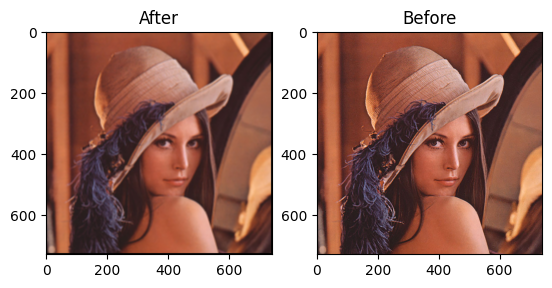

In [48]:
def lisse(im,size_filtre):
    assert(size_filtre%2 == 1)      #filtre de taille impaire
    filtre = np.array([[1/(size_filtre**2)]*size_filtre]*size_filtre)
    return linear_filter_RGB(im,filtre)

im_temp = lisse(im_lena,7)
show(im_temp,im_lena)


### b. accentuation

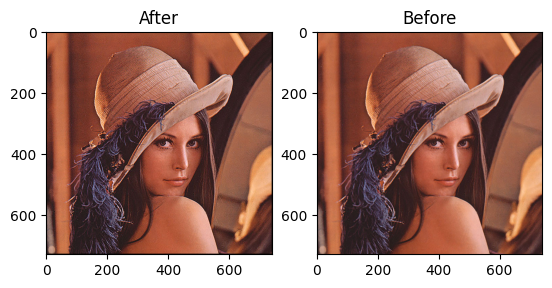

In [49]:
def accentuate(im):
    filtre = np.array([[0,-0.5,0],
                       [-0.5,3,-0.5],
                       [0,-0.5,0]])
    return linear_filter_RGB(im,filtre)

im_temp = accentuate(im_lena)
show(im_temp,im_lena)

### c. gradient

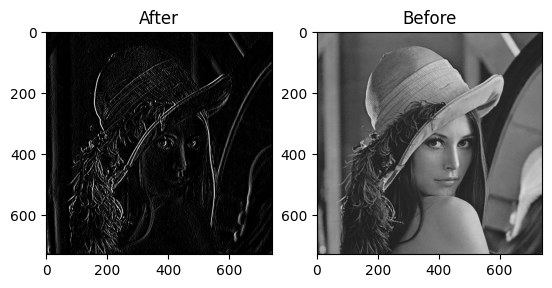

In [50]:
def gradient_vertical(im):
    filtre = np.array([[-1,0,1],
                       [-2,0,2],
                       [-1,0,1]])
    
    return linear_filter_grey(im,filtre)

im_temp = gradient_vertical(im_lena_gray)
show(im_temp,im_lena_gray,cmap="gray",cmap_ref="gray")

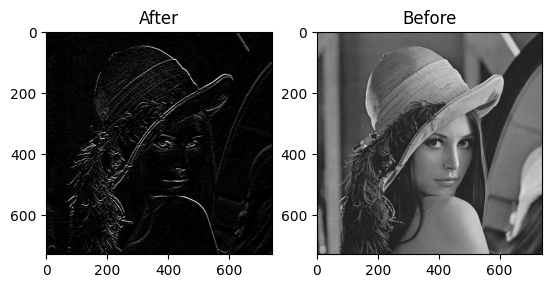

In [51]:
def gradient_horizontal(im):
    filtre = np.array([[-1,-2,-1],
                       [0,0,0],
                       [1,2,1]])
    return linear_filter_grey(im,filtre)

im_temp = gradient_horizontal(im_lena_gray)
show(im_temp,im_lena_gray,cmap="gray",cmap_ref="gray")